In [20]:
import os
import cv2
from paddleocr import PPStructure,save_structure_res
from paddleocr.ppstructure.recovery.recovery_to_doc import sorted_layout_boxes, convert_info_docx
import pandas as pd
import matplotlib.pyplot as plt
from tablepyxl import tablepyxl
from copy import deepcopy
import io

In [169]:
#read image table
path = 'Sample/IOL.png'
img = cv2.imread(path)
img = cv2.resize(img, (1000, 1500), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
img = img[600:795, 80:520]

In [ ]:
# read circle
path = 'Sample/S__33579013.jpg'
img = cv2.imread(path)
img = cv2.resize(img, (1600, 1100), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
img = img[400:800 , 750:1050]
plt.imshow(img)

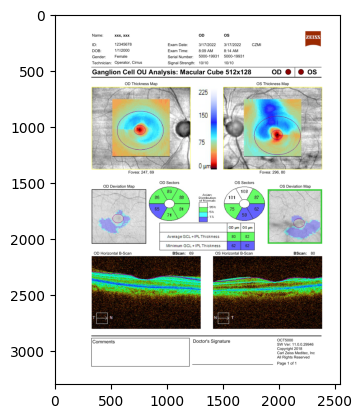

In [185]:
# ocr circle
path = 'Sample/out.png'
img = cv2.imread(path)
# img = cv2.resize(img, (1600, 1100), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
# img = img[1530:1850, 1500:1900]
plt.imshow(img)

In [193]:
tmp =  {"name1": 
            [
            {
                "id": "name",
                "type": "text",
                "box_pos": [127.440, 741.671, 204.817, 749.921],
            },
            {
                "id": "id",
                "type": "text",
                "box_pos": [127.440, 721.511, 164.136, 729.761],
            },
            {
                "id": "DOB",
                "type": "text",
                "box_pos": [127.440, 708.551, 164.119, 716.801],
            }
            ], 
        "name2": 
            [
            {
                "id": "name",
                "type": "text",
                "box_pos": [127.440, 741.671, 204.817, 749.921],
            },
            {
                "id": "id",
                "type": "text",
                "box_pos": [127.440, 721.511, 164.136, 729.761],
            },
            {
                "id": "DOB",
                "type": "text",
                "box_pos": [127.440, 708.551, 164.119, 716.801],
            }
            ]
        }

In [197]:
data_input = [{
        "template_name": tmp['name1'],
        "path": 'Sample/out.png',
        "page": 1,
}]

In [198]:
data_input[0]["template_name"]

[{'id': 'name',
  'type': 'text',
  'box_pos': [127.44, 741.671, 204.817, 749.921]},
 {'id': 'id', 'type': 'text', 'box_pos': [127.44, 721.511, 164.136, 729.761]},
 {'id': 'DOB', 'type': 'text', 'box_pos': [127.44, 708.551, 164.119, 716.801]}]

In [184]:
# load model
def load_model():
    table_engine = PPStructure(recovery=True, lang='en')
    return table_engine

table_engine = load_model()

[2023/12/10 23:27:58] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\earth/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\earth/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_leng

In [161]:
# predict
result = table_engine(img)        
result_cp = deepcopy(result)
region = result_cp[0]
roi_img = region.pop('img')
# html = region['res']['html']
# wb = tablepyxl.document_to_workbook(html)

[2023/12/10 23:06:04] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.01308441162109375
[2023/12/10 23:06:04] ppocr DEBUG: rec_res num  : 6, elapsed : 0.015427112579345703


In [180]:
# predict
result = table_engine(img)        
result_cp = deepcopy(result)

df_ls = []
for region in result_cp:
    # if region is table
    if 'html' in region['res']:
        html = region['res']['html']
        wb = tablepyxl.document_to_workbook(html)
        output = io.BytesIO()
        wb.save(output)
        output.seek(0)
        df = pd.read_excel(output)
        df_ls.append(df)
    # else region is circle
    else:
        text_ls = []
        for text in region['res']:
            text_ls.append(text['text'])
        df = pd.DataFrame(text_ls)
        df_ls.append(df)
        
pd.concat(df_ls, axis=0)

[2023/12/10 23:14:41] ppocr DEBUG: dt_boxes num : 29, elapse : 0.05486917495727539
[2023/12/10 23:14:41] ppocr DEBUG: rec_res num  : 29, elapse : 0.07657027244567871
